## Conifuration

In [ ]:
#import the lib for contrastive learning framework
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.4 MB/s 
     |████████████████████████████████| 151 kB 11.2 MB/s 
     |████████████████████████████████| 585 kB 11.7 MB/s 
     |████████████████████████████████| 117 kB 23.6 MB/s 
     |████████████████████████████████| 79 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 23.3 MB/s 
     |████████████████████████████████| 419 kB 32.0 MB/s 
     |████████████████████████████████| 140 kB 16.6 MB/s 
     |████████████████████████████████| 1.1 MB 23.4 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 37.1 MB/s 
     |████████████████████████████████| 271 kB 37.7 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=2754775bcc2d1f80c58331ee327712d85502d598397b91b4918294bf1ef8555a
  Stored in directory: /roo

In [ ]:
import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead

from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NTXentLoss
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimCLRProjectionHead

In [ ]:
import math
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot
import seaborn as sns

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn import mixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering

import tensorboard
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

import matplotlib 
import matplotlib.pyplot as plt
#import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.utils import shuffle

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics.pairwise import cosine_similarity

import random
from torch.nn.modules.loss import MSELoss
from sklearn.neighbors import KDTree
#from kmodes.kprototypes import KPrototypes

from scipy.io.arff import loadarff
from sklearn.preprocessing import MinMaxScaler 
from sklearn.datasets import make_classification

## Load Dataset Pendigits and Check Clustering Result with the Baseline Method Kmeans

In [ ]:
# set the path to the dataset
path_to_data = '/content/drive/MyDrive/Colab_Notebooks/pendigits.csv'

In [ ]:
data = pd.read_csv(path_to_data)

X_ds = data.copy()
X_ds = X_ds.drop(['class'], axis=1)
X_ds = pd.DataFrame(X_ds).to_numpy()

y_ds = data.copy()
y_ds = y_ds['class']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


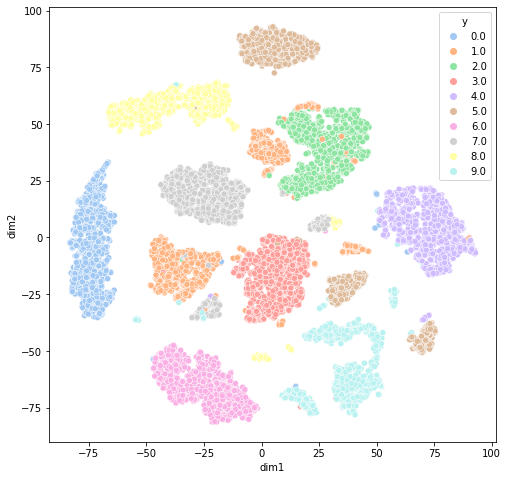

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_ds)
data_X_tsne = np.vstack((X_tsne.T, y_ds)).T
df_tsne = pd.DataFrame(data_X_tsne, columns=['dim1', 'dim2', 'y'])
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_tsne, hue='y', x='dim1', y='dim2', palette='pastel')
plt.show()

In [ ]:
#check the clustering result with Kmeans
kmeans_ori = KMeans(n_clusters=10).fit(X_ds)
kmeans_labels_ori = kmeans_ori.labels_

normalized_mutual_info_score(kmeans_labels_ori, y_ds)

0.6930072473203124

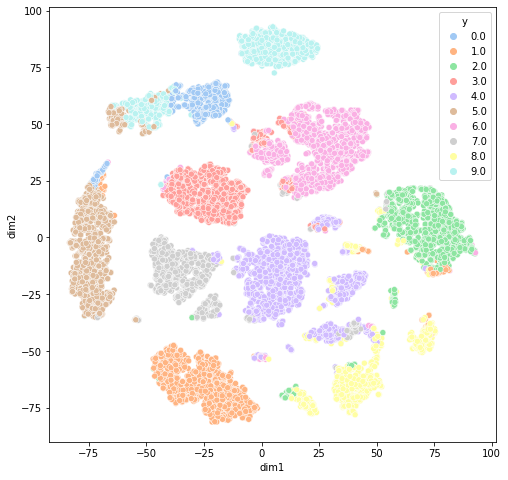

In [ ]:
#tsne = TSNE(n_components=2)
#X_tsne = tsne.fit_transform(X_ds)
data_X_tsne = np.vstack((X_tsne.T, kmeans_labels_ori)).T
df_tsne = pd.DataFrame(data_X_tsne, columns=['dim1', 'dim2', 'y'])
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_tsne, hue='y', x='dim1', y='dim2', palette='pastel')
plt.show()

## Data Augmentation

####MixUp

In [ ]:
def mixup(data):
  view = data.copy()
  for i in range(len(view)):
    random_row_index = random.randint(0, len(view)-1)
    view[i] = view[i]*0.5  + view[random_row_index]*0.5
  return view

####MixCut

In [ ]:
def mixcut(data):
  data_copy = data.copy()
  view = data.copy()
  mask_len = 100

  for i in range(len(data_copy)):
    random_row_id = random.randint(0, len(data_copy)-1)
    random_column_id = random.randint(0, data_copy.shape[1]-mask_len)
    view[i,random_column_id:(random_column_id+mask_len)] = data_copy[random_row_id,random_column_id:(random_column_id+mask_len)]
  return view

#### Masking with mean

In [ ]:
def get_random_indices(data, portion_of_mask):
  return np.random.choice(data.shape[1], size=np.floor(data.shape[1]*portion_of_mask).astype(int), replace=False)

In [ ]:
def masking_with_mean(data, portion_of_mask):
  mean = np.mean(data, axis=0)
  column_mu = np.mean(data, axis=0)
  column_std = np.std(data, axis=0)

  view = data.copy()

  for i in range(len(data)): 
    masked_indices = get_random_indices(data, portion_of_mask)
   
    for j in range(len(mean)):
      if j in masked_indices:
        view[i,j] = column_mu[j]
              
  return view

####Masking with random value in domain range

In [ ]:
def masking_with_random(data, portion_of_mask):
  mean = np.mean(data, axis=0)
  column_mu = np.mean(data, axis=0)
  column_std = np.std(data, axis=0)
  column_min = np.minimum(data)
  column_max = np.maximum(data)

  view = data.copy()

  for i in range(len(data)): 
    masked_indices = get_random_indices(data, portion_of_mask)
   
    for j in range(len(mean)):
      if j in masked_indices:
        view[i,j] = random.randint(column_min[j], column_max[j])
              
  return view

####Masking with margin distribution

In [ ]:
def masking_with_margin_distribution(data, portion_of_mask):
  mean = np.mean(data, axis=0)
  column_mu = np.mean(data, axis=0)
  column_std = np.std(data, axis=0)

  view = data.copy()

  for i in range(len(data)): 
    masked_indices = get_random_indices(data, portion_of_mask)
   
    for j in range(len(mean)):
      if j in masked_indices:
        view[i,j] = np.random.normal(column_mu[j], column_std[j])
              
  return view

####Upsampling (SMOTE like)

In [ ]:
#put all data points in kd-tree for fast searching
kdtree = KDTree(X_ds, leaf_size=2)

In [ ]:
#get random point in the k nearest neighbors
def get_idx_random_knn(x,k):
   _, ids = kdtree.query(x.reshape(1, -1), k=k)
   ids = ids.flatten()
   ids = ids[1:-1]
   random_id = np.random.choice(ids, 1)
   return random_id

In [ ]:
#mix up with a random near neighbor 
def mixup_random_neighbor(data, k):
  view = data.copy()
  for i in range(len(view)):
    point = data[i]
    random_neighbor_id = get_idx_random_knn(x=point, k=k)
    view[i] = 0.5*data[i] + 0.5*data[random_neighbor_id]
  return view

In [ ]:
#a random neighbor as augmentation
def random_near_neighbor(data, k):
  view = data.copy()
  for i in range(len(view)):
    point = data[i]
    random_neighbor_id = get_idx_random_knn(x=point, k=k)
    view[i] = data[random_neighbor_id]
  return view

##Create Model and Train with Augmented Data

In [ ]:
class MyDataSet(Dataset):
  def __init__(self, view1, view2):
 
    X_view1 = view1.copy()
    X_view2 = view2.copy()
    self.X_view1 = X_view1.copy().astype(np.float32)
    self.X_view2 = X_view2.copy().astype(np.float32)
  
  def __len__(self):
    return len(self.X_view1)
  
  def __getitem__(self, idx):
    return self.X_view1[idx], self.X_view2[idx]

In [ ]:
# define the NN architecture
class convBackbone(nn.Module):
    def __init__(self):
        super(convBackbone, self).__init__()

        #turn on dropout for testing the 'cropping' data augmentation 
        #self.dropout = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(16, 16, bias=False)
        self.bn1 = nn.BatchNorm1d(16)

        self.fc2 = nn.Linear(16, 16, bias=False)
        self.bn2 = nn.BatchNorm1d(16)

        self.fc3 = nn.Linear(16, 8, bias=False)
        self.bn3 = nn.BatchNorm1d(8)


    def forward(self, x):

        #turn on dropout for testing the 'cropping' data augmentation 
        #x = self.dropout(x)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.bn3(self.fc3(x))
                
        return x

In [ ]:
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(8, 4, 8)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return x,z

backbone = convBackbone()
model = SimCLR(backbone)

In [ ]:
criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9,weight_decay=1e-4)

#cosine annealing lr
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=800, eta_min=0)

In [ ]:
view1 = random_near_neighbor(X_ds, 18)
view2 = random_near_neighbor(X_ds, 19)

#turn on the following to test other augmentations

#view1 = mixup_random_neighbor(X_ds, 15)
#view2 = mixup_random_neighbor(X_ds, 15)

#view1 = mixup(X_ds)
#view2 = mixup(X_ds)

#view1 = mixcut(X_ds)
#view2 = mixcut(X_ds)

#view1 = masking_with_mean(X_ds, 0.4)
#view2 = masking_with_mean(X_ds, 0.4)

#view1 = masking_with_random(X_ds, 0.4)
#view2 = masking_with_random(X_ds, 0.4)

#view1 = masking_with_margin_distribution(X_ds, 0.4)
#view2 = masking_with_margin_distribution(X_ds, 0.4)

train_ds = MyDataSet(view1, view2)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

for epoch in range(500):
    total_loss = 0
    for x0, x1 in train_dl:

        x0 = x0.to(device)
        x1 = x1.to(device)
        _,z0 = model(x0)
        _,z1 = model(x1)

        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

    avg_loss = total_loss / len(train_dl)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

epoch: 00, loss: 6.00204
epoch: 01, loss: 5.59302
epoch: 02, loss: 5.50770
epoch: 03, loss: 5.46121
epoch: 04, loss: 5.44572
epoch: 05, loss: 5.43963
epoch: 06, loss: 5.43309
epoch: 07, loss: 5.42970
epoch: 08, loss: 5.42678
epoch: 09, loss: 5.42320
epoch: 10, loss: 5.42071
epoch: 11, loss: 5.41926
epoch: 12, loss: 5.41830
epoch: 13, loss: 5.41727
epoch: 14, loss: 5.41671
epoch: 15, loss: 5.41559
epoch: 16, loss: 5.41513
epoch: 17, loss: 5.41415
epoch: 18, loss: 5.41446
epoch: 19, loss: 5.41335
epoch: 20, loss: 5.41453
epoch: 21, loss: 5.41362
epoch: 22, loss: 5.41377
epoch: 23, loss: 5.41316
epoch: 24, loss: 5.41305
epoch: 25, loss: 5.41344
epoch: 26, loss: 5.41357
epoch: 27, loss: 5.41420
epoch: 28, loss: 5.41330
epoch: 29, loss: 5.41422
epoch: 30, loss: 5.41305
epoch: 31, loss: 5.41298
epoch: 32, loss: 5.41305
epoch: 33, loss: 5.41182
epoch: 34, loss: 5.41063
epoch: 35, loss: 5.41172
epoch: 36, loss: 5.41074
epoch: 37, loss: 5.40971
epoch: 38, loss: 5.41037
epoch: 39, loss: 5.40944


##Check the Training Result

In [ ]:
ds_cl= MyDataSet(X_ds, X_ds)
dl_cl = DataLoader(ds_cl, batch_size=256)

In [ ]:
embeddings = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    for dl_cl1, dl_cl2 in dl_cl:

        dl_cl1 = dl_cl1.to(device)
        x,z = model(dl_cl1)
        
        # store the embeddings in lists
        embeddings.append(x)

# concatenate the embeddings, targets and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [ ]:
test = (embeddings - embeddings.mean(axis=0)) / (embeddings.std(axis=0))

In [ ]:
#KMeans in latent space
kmeans_backbone = KMeans(n_clusters=10).fit(test)
kmeans_labels_backbone = kmeans_backbone.labels_

In [ ]:
normalized_mutual_info_score(kmeans_labels_backbone, y_ds)

0.7721229574921573

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


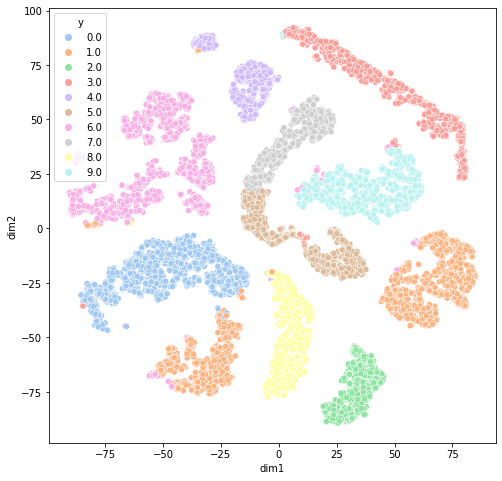

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embeddings)
data_X_tsne = np.vstack((X_tsne.T, kmeans_labels_backbone)).T
df_tsne = pd.DataFrame(data_X_tsne, columns=['dim1', 'dim2', 'y'])
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_tsne, hue='y', x='dim1', y='dim2', palette='pastel')
plt.show()

In [ ]:
#NMI increases from 0.69 to 0.77